In [1]:
import warnings
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from scipy import linalg
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import timeit

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

np.random.seed(123)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

<ipython-input-1-c790307d65ce>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [9]:
def create_multioutput_table(long=False, loc_mobility=None, loc_covid=None):
    
    if loc_mobility==None:
        loc_mobility="./Data/Google/Global_Mobility_Report.csv"
        
    if loc_covid==None:
        loc_covid="./Data/Microsoft/COVID_CASES.csv"
     
    # Load the population of each state. It will be needed for the computation of recovered, infected and susceptible
    population = pd.read_excel(
    "./Data/Population/US_population_raw_data.xls")
    STATE_POPULATION = dict(zip(population[1:].Location, population[1:].COVIDTotal))
        
    # Load & preprocess Mobility Data
    mobility_data = pd.read_csv(
        "./Data/Google/Global_Mobility_Report.csv", 
        encoding="ISO-8859-1", 
        parse_dates=["date"], 
        dayfirst=True)
    
    mobility_data = mobility_data[
        (mobility_data["country_region"]=="United States") & 
        (~mobility_data["sub_region_1"].isnull()) &
        (mobility_data["sub_region_2"].isnull())].copy()
    
    mobility_data_us = mobility_data.iloc[:,7:] # keep only relevant columns
    mobility_data_us["state"] = mobility_data["sub_region_1"]
    mobility_data_us.iloc[:,1:-1] = mobility_data_us.iloc[:,1:-1].apply(lambda x: x/100 + 1)
    mobility_data_us.reset_index(drop=True, inplace=True)
    
    mobility_data_us = pd.DataFrame({
        "state": mobility_data_us["state"],
        "date": mobility_data_us["date"],
        "HOME": mobility_data_us['residential_percent_change_from_baseline'],
        "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
        "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
        "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)})
    
    # Load & preprocess COVID Data
    ms_covid = pd.read_csv(
        "./Data/Microsoft/COVID_CASES.csv", 
        encoding="ISO-8859-1", 
        parse_dates=["Updated"], 
        dayfirst=False)
    
    ms_us_covid = ms_covid[
        (ms_covid["Country_Region"]=="United States") & 
        (~ms_covid["AdminRegion1"].isnull()) &
        (ms_covid["AdminRegion2"].isnull())]
    
    ms_us_covid = ms_us_covid.loc[:,["AdminRegion1", "Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]].copy()
    ms_us_covid.rename(columns={"AdminRegion1": "state"}, inplace=True)
    ms_us_covid.reset_index(drop=True, inplace=True)
    
    processed_dfs = []

    for state_name in ms_us_covid["state"].unique():
        d = ms_us_covid[ms_us_covid["state"] == state_name]
        d = d.fillna(method='ffill').fillna(0)
        d["I"] = d["Confirmed"] - d["Deaths"] - d["Recovered"]

        d["S"] = int(STATE_POPULATION[state_name]) - d["I"]

        d["ConfirmedChange"] = np.log(d["ConfirmedChange"].rolling(7).median()+1)
        d["I"] = d["I"].rolling(7).median()
        d["S"] = d["S"].rolling(7).median()
        d.drop(["Confirmed", "Deaths", "Recovered"], axis=1, inplace=True)
        d.dropna(inplace=True)
        processed_dfs.append(d)
    
    ms_us_covid = pd.concat(processed_dfs)
    ms_us_covid["WEEKDAY"] = (ms_us_covid["Updated"].dt.dayofweek < 5).astype(int)
    ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear
    
    #Merge the two datasets
    final_data = ms_us_covid.merge(
    mobility_data_us, how='left', left_on=["state", "Updated"], right_on=["state", "date"])
    final_data.dropna(inplace=True)
    final_data.drop(["date"], axis=1, inplace=True)
    final_data.reset_index(drop=True, inplace=True)
    
    
    if long==False: # Long table format. We create a column to name each country and we concat the tables.           
        for i, state_name in enumerate(np.unique(final_data.state)):
            if i==0:
                temp_data = final_data[final_data["state"]==state_name]
                temp_data.drop(["state"], axis=1, inplace=True)
                temp_data.reset_index(drop=True, inplace=True)
                col_list = [str(col) + '_' + str(state_name) for col in temp_data.columns]
                temp_data.columns = col_list
            else:
                data_batch = final_data[final_data["state"]==state_name]
                data_batch.drop(["state"], axis=1, inplace=True)
                data_batch.reset_index(drop=True, inplace=True)
                col_list = [str(col) + '_' + str(state_name) for col in data_batch.columns]
                data_batch.columns = col_list
                temp_data = pd.concat([temp_data, data_batch], axis=1)
        final_data = temp_data.copy()

        
    return(final_data) 

In [10]:
final_data = create_multioutput_table(long=False)

/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
final_data.dropna(axis=0, inplace=True)

In [12]:
final_data.shape

(153, 170)

In [76]:
# Split the dataset
y = final_data.filter(regex='^ConfirmedChange', axis=1).to_numpy() # Extract columns that contain each country's daily COVID cases
y_cols = final_data.filter(regex='^ConfirmedChange', axis=1).columns


X = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).to_numpy() # Extract mobility and SI data for each country
X_cols = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).columns

X_train, X_test = X[:-21,:], X[-21:,:]
y_train, y_test = y[:-21,:], y[-21:,:]

y_scaler = preprocessing.StandardScaler().fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)
#y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
#X = x_scaler.transform(X)

In [79]:
X_cols[list(range(0, 8))]

Index(['I_Alabama', 'S_Alabama', 'WEEKDAY_Alabama', 'index_Alabama',
       'HOME_Alabama', 'WORK_Alabama', 'RECREATIONAL_Alabama',
       'OTHER_Alabama'],
      dtype='object')

In [80]:
print("The shape of y is: {0} and the shape of X is: {1}".format(y.shape, X.shape))
print("The shape of X_train is: {0} and the shape of X_test is: {1}".format(X_train.shape, X_test.shape))

The shape of y is: (153, 17) and the shape of X is: (153, 136)
The shape of X_train is: (132, 136) and the shape of X_test is: (21, 136)


In [93]:
states_list = [col[13:] for col in final_data.filter(regex="^RECREATIONAL").columns.values]

In [88]:
# Set the parameters of the model, kernels, inducing points, number of outputs.
P = len(y_cols)

# Create list of kernels for each output
# Each country has 8 covariates, I, S, t, weekday, mobility
kern_list = [gpflow.kernels.SquaredExponential(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) * \
             gpflow.kernels.Linear(active_dims=list(range(_, _+8))) *  \
             gpflow.kernels.RationalQuadratic(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)

Zinit = X_train[np.random.randint(X_train.shape[0], size=15), :]
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpflow.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpflow.inducing_variables.SeparateIndependentInducingVariables(iv_list)

In [89]:
# create SVGP model
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [90]:
# Use natural gradients to optimise the variational parameters
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

# use Adam to optimise the kernel parameters
adam_opt = tf.optimizers.Adam(0.01)
natgrad_opt = NaturalGradient(gamma=0.1)

variational_params = [(m.q_mu, m.q_sqrt)]

train_loss = m.training_loss_closure((X_train, y_train))

In [92]:
logf = []
length1 = []
length2 = []
rmse = []
tr_bias = []
tr_var = []
test_rmse = []
tst_bias = []
tst_var = []
complexity = []

for _ in range(ci_niter(1000)):
    natgrad_opt.minimize(train_loss, var_list=variational_params)
    adam_opt.minimize(train_loss, var_list=m.trainable_variables)
    elbo = -train_loss().numpy()
    logf.append(elbo)
        
    # Model complexity
    complexity.append(np.sum(-0.5*tf.linalg.logdet(kernel(X_train))))
    
    # For this particular kernel we take Alabama [0], Squared Exp ARD [0] and the I [0] and recreational [6] lengthscales
    length1.append(m.kernel.kernels[0].kernels[0].lengthscales[0].numpy())
    length2.append(m.kernel.kernels[0].kernels[0].lengthscales[6].numpy())
    
    # Training error
    mean_predict, _ = m.predict_y(X_train)
    rmse.append(np.sqrt(np.mean((y_train - mean_predict)**2)))
    
    # Training bias-variance
    tr_bias.append(np.sqrt(np.mean((y_train - np.mean(mean_predict, axis=0))**2)))
    tr_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))
    
    # Test error
    mean_predict, _ = m.predict_y(X_test)
    test_rmse.append(np.sqrt(np.mean((y_test - mean_predict)**2)))
    
    # Test bias-variance
    tst_bias.append(np.sqrt(np.mean((y_test - np.mean(mean_predict, axis=0))**2)))
    tst_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))  

    
logf = np.array(logf)
length1 = np.array(length1)
length2 = np.array(length2)
rmse = np.array(rmse)
tr_bias = np.array(tr_bias)
tr_var = np.array(tr_var)
test_rmse = np.array(test_rmse)
tst_bias = np.array(tst_bias)
tst_var = np.array(tst_var)
complexity = np.array(complexity)

Instructions for updating:
Use fn_output_signature instead


Text(0.5, 0.92, 'Alabama, Squared Exponential Kernel')

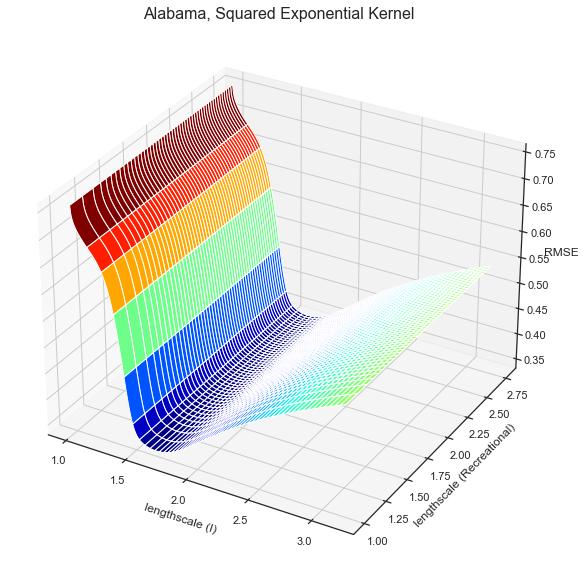

In [101]:
# Try to plot a 3D figure of a SE lengthscale of infected, a SE lengthscale of recreational, of the training set RMSE
# over 1000 optimization iterations.
xaxis, yaxis = np.meshgrid(length1, length2)
zaxis, yaxis = np.meshgrid(rmse, length2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xaxis, yaxis, zaxis, cmap='jet')
ax.set_xlabel('lengthscale (I)')
ax.set_ylabel('lengthscale (Recreational)')
ax.set_zlabel('RMSE')
ax.set_title('Alabama, Squared Exponential Kernel', fontsize=16)

Text(0.5, 1.0, 'Variance of the training data')

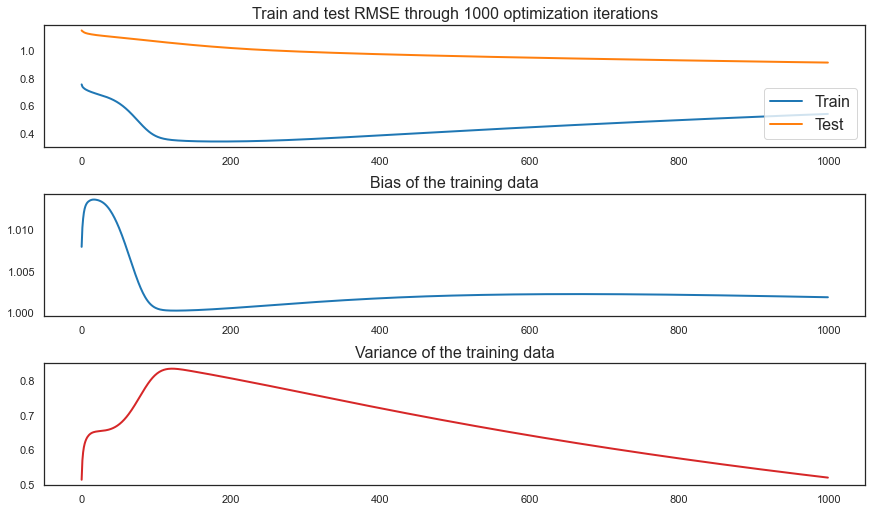

In [95]:
# Plot the evolution of train and test RMSE through the 1000 optimization iterations
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
spec = GridSpec(ncols=1, nrows=3, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(rmse, color='tab:blue', label='Train', linewidth=2)
ax0.plot(test_rmse, color='tab:orange', label='Test', linewidth=2)
#ax0.axvline(x=np.where(rmse == rmse.min()), color='red')
ax0.legend(loc='lower right', fontsize=16)
ax0.set_title('Train and test RMSE through 1000 optimization iterations', fontsize=16)

ax1 = fig.add_subplot(spec[1, 0])
ax1.plot(tr_bias, color='tab:blue', label='Bias', linewidth=2)
ax1.set_title('Bias of the training data', fontsize=16)

ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(tr_var, color='tab:red', label='Variance', linewidth=2)
ax2.set_title('Variance of the training data', fontsize=16)

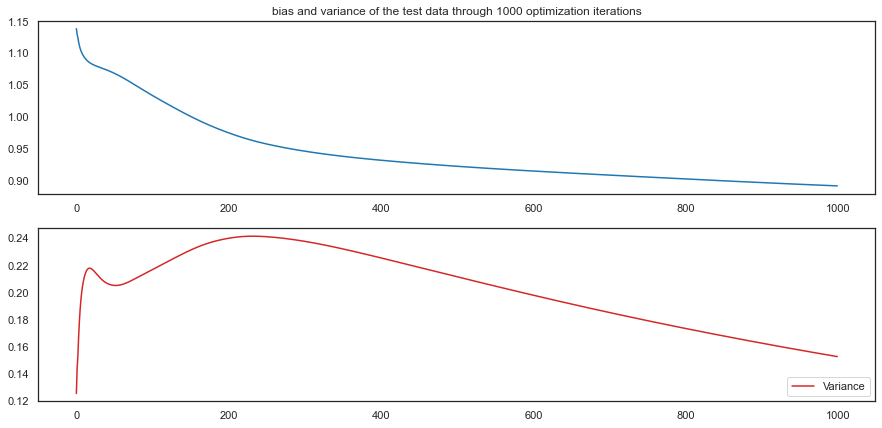

In [96]:
# Plot the evolution of bias and variance in the test set through the 1000 optimization iterations
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
ax[0].plot(np.array(tst_bias), color='tab:blue', label='Bias')
ax[0].set_title('bias and variance of the test data through 1000 optimization iterations')
ax[1].plot(np.array(tst_var), color='tab:red', label='Variance')
plt.legend(loc='lower right')

In [97]:
# Train predictions
mean_train, var_train = m.predict_y(X_train)
# Test predictions
mean_test, var_test = m.predict_y(X_test)
# Full predictions (train + test)
# using the trained based normalisation (x_scaler)
mean, var = m.predict_y(x_scaler.transform(X))
_y = y_scaler.transform(y)

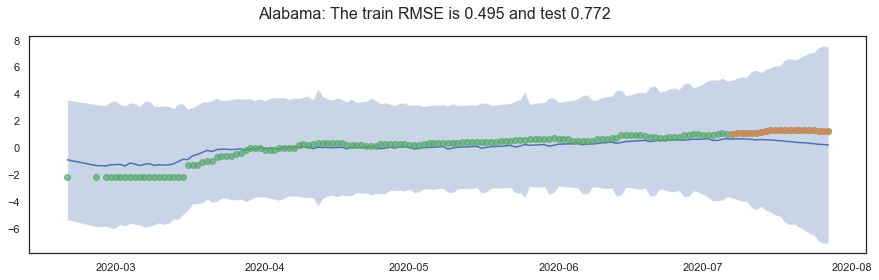

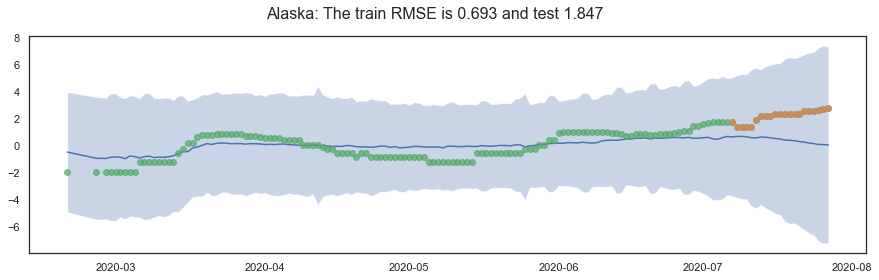

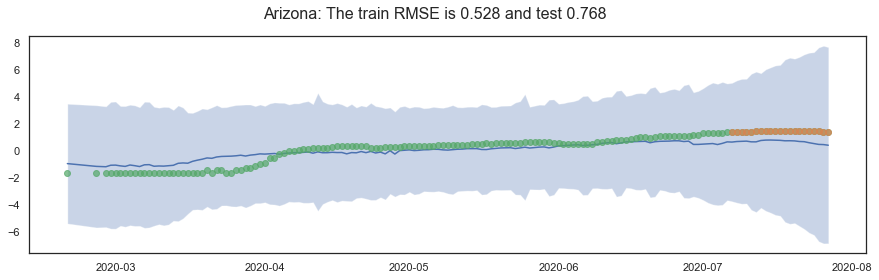

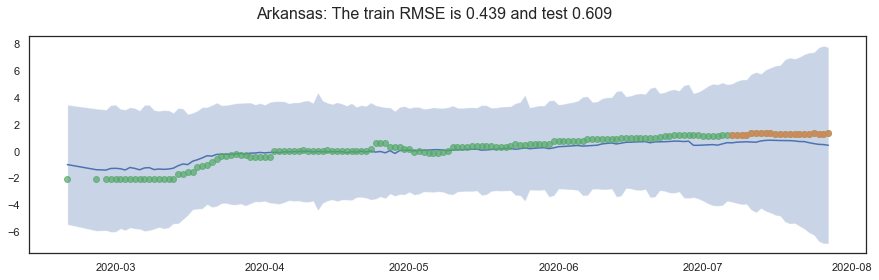

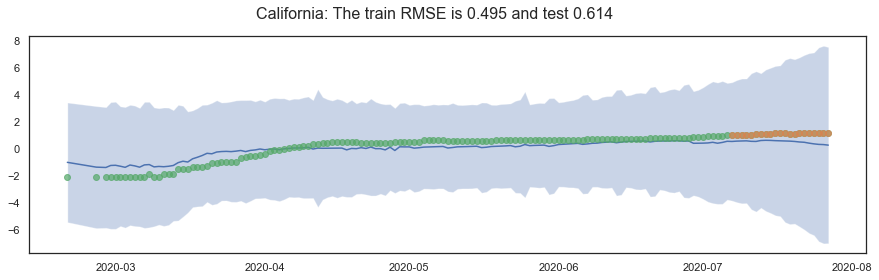

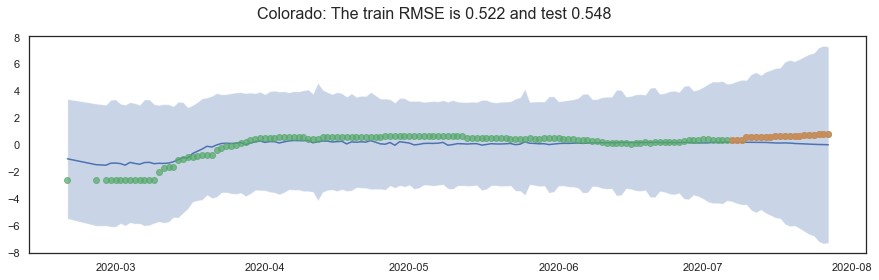

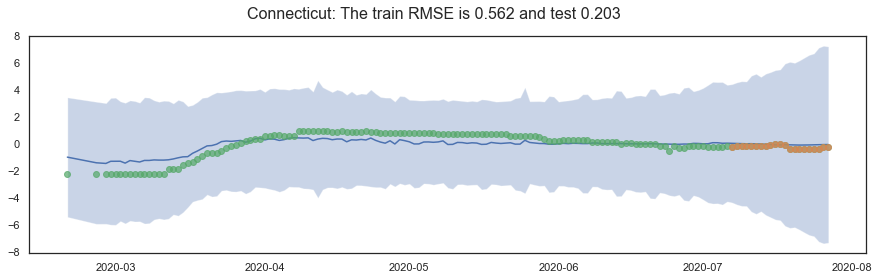

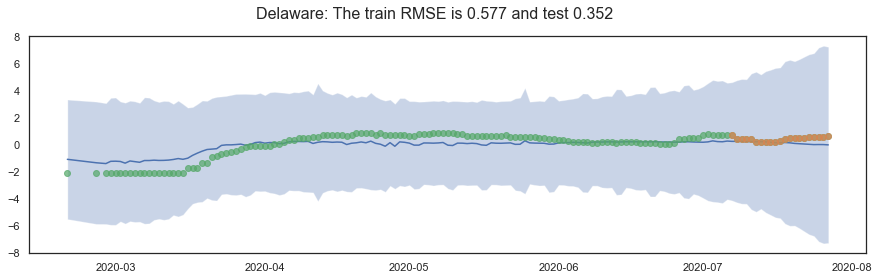

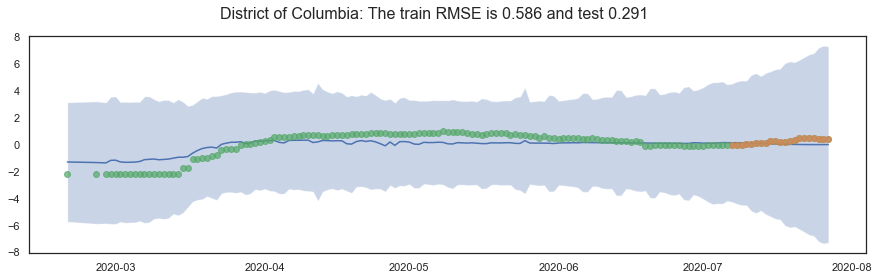

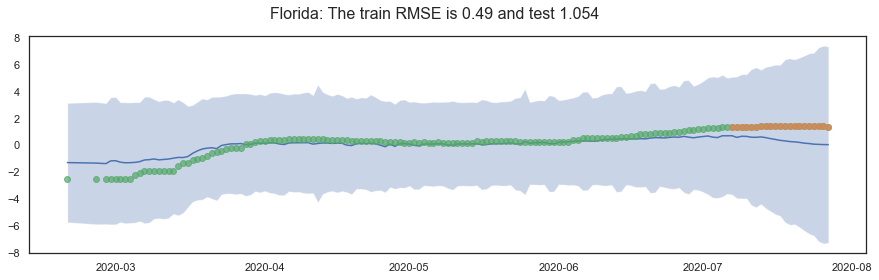

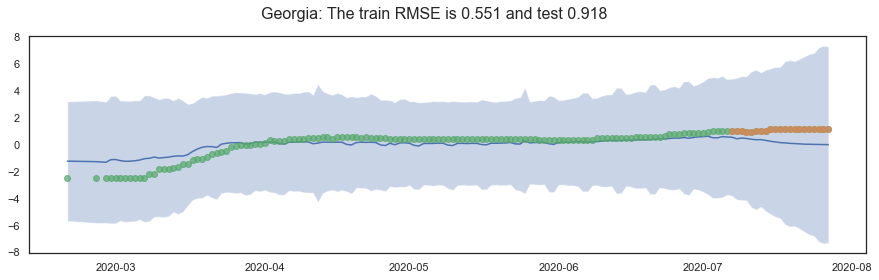

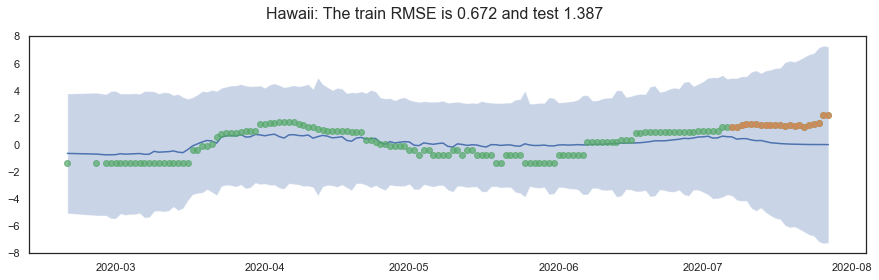

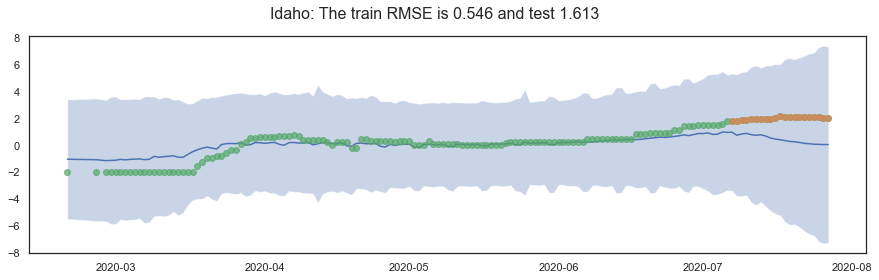

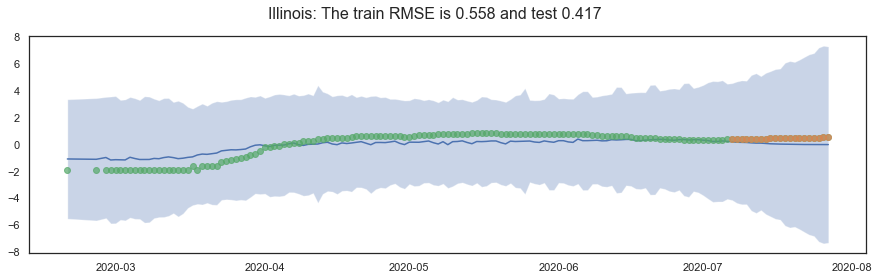

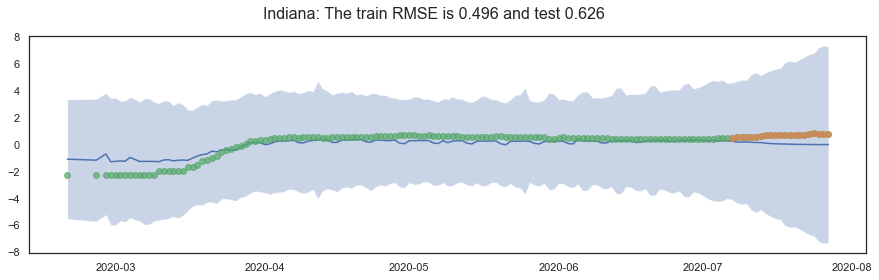

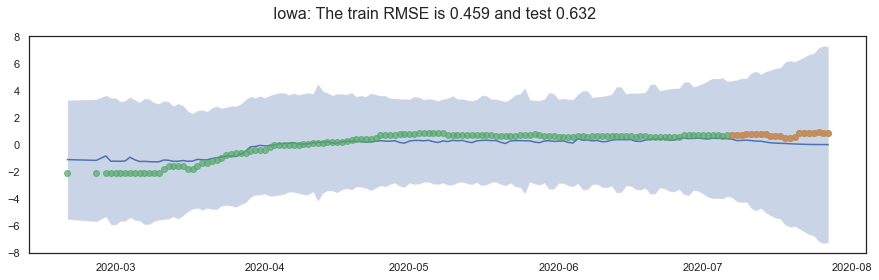

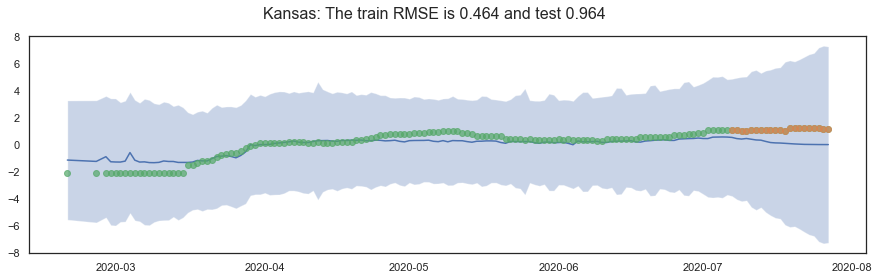

In [100]:
t = final_data[["Updated_Alabama"]].to_numpy()

for s, state_name in enumerate(states_list):
    
    train_error = np.sqrt(np.mean((y_train[:, s] - mean_train[:, s])**2))
    test_error = np.sqrt(np.mean((y_test[:, s] - mean_test[:, s])**2))
    
    _fig, ax = plt.subplots(1, figsize=(15, 4))
    
    _fig.suptitle("{0}: The train RMSE is {1} and test {2}".format(state_name, np.round(train_error, 3), 
                                                                   np.round(test_error, 3)), fontsize=16)
    ax.plot(t, mean[:, s], "-", c="C0")
    lo = (mean[:, s] - 2 * tf.sqrt(var[:, s])).numpy()
    hi = (mean[:, s] + 2 * tf.sqrt(var[:, s])).numpy()
    ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(t, _y[:, s], "o", c="C2", alpha=0.7, label="train")
    ax.plot(t[-21:, :], _y[-21:, s], "o", c="C1", alpha=0.7, label="test")

## Perform multioutput on 2-3-4 states

In [48]:
final_data = create_multioutput_table(long=False)
final_data.dropna(axis=0, inplace=True)

/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
final_data.filter(regex=("^Updated")).columns

Index(['Updated_Alabama', 'Updated_Alaska', 'Updated_Arizona',
       'Updated_Arkansas', 'Updated_California', 'Updated_Colorado',
       'Updated_Connecticut', 'Updated_Delaware',
       'Updated_District of Columbia', 'Updated_Florida', 'Updated_Georgia',
       'Updated_Hawaii', 'Updated_Idaho', 'Updated_Illinois',
       'Updated_Indiana', 'Updated_Iowa', 'Updated_Kansas'],
      dtype='object')

In [49]:
#final_data = final_data.filter(regex=("Alabama$|California$"))
final_data = final_data.filter(regex=("Alabama$|California$|Florida$"))

In [50]:
# Split the dataset
y = final_data.filter(regex='^ConfirmedChange', axis=1).to_numpy() # Extract columns that contain each country's daily COVID cases
y_cols = final_data.filter(regex='^ConfirmedChange', axis=1).columns


X = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).to_numpy() # Extract mobility and SI data for each country
X_cols = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).columns

X_train, X_test = X[:-21,:], X[-21:,:]
y_train, y_test = y[:-21,:], y[-21:,:]

y_scaler = preprocessing.StandardScaler().fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)
#y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
#X = x_scaler.transform(X)

In [51]:
X_cols[list(range(0, 8))]

Index(['I_Alabama', 'S_Alabama', 'WEEKDAY_Alabama', 'index_Alabama',
       'HOME_Alabama', 'WORK_Alabama', 'RECREATIONAL_Alabama',
       'OTHER_Alabama'],
      dtype='object')

In [52]:
# Set the parameters of the model, kernels, inducing points, number of outputs.
P = len(y_cols)

# Create list of kernels for each output
# Each country has 8 covariates, I, S, t, weekday, mobility
kern_list = [gpflow.kernels.SquaredExponential(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) * \
             gpflow.kernels.Linear(active_dims=list(range(_, _+8))) *  \
             gpflow.kernels.RationalQuadratic(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)

Zinit = X_train[np.random.randint(X_train.shape[0], size=15), :]
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpflow.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpflow.inducing_variables.SeparateIndependentInducingVariables(iv_list)

In [53]:
# create SVGP model
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

# Use natural gradients to optimise the variational parameters
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

# use Adam to optimise the kernel parameters
adam_opt = tf.optimizers.Adam(0.01)
natgrad_opt = NaturalGradient(gamma=0.1)

variational_params = [(m.q_mu, m.q_sqrt)]

train_loss = m.training_loss_closure((X_train, y_train))

In [54]:
logf = []
length1 = []
length2 = []
rmse = []
tr_bias = []
tr_var = []
test_rmse = []
tst_bias = []
tst_var = []
complexity = []

for _ in range(ci_niter(1000)):
    natgrad_opt.minimize(train_loss, var_list=variational_params)
    adam_opt.minimize(train_loss, var_list=m.trainable_variables)
    elbo = -train_loss().numpy()
    logf.append(elbo)
        
    # Model complexity
    complexity.append(np.sum(-0.5*tf.linalg.logdet(kernel(X_train))))
    
    # For this particular kernel we take Alabama [0], Squared Exp ARD [0] and the I [0] and recreational [6] lengthscales
    length1.append(m.kernel.kernels[0].kernels[0].lengthscales[0].numpy())
    length2.append(m.kernel.kernels[0].kernels[0].lengthscales[6].numpy())
    
    # Training error
    mean_predict, _ = m.predict_y(X_train)
    rmse.append(np.sqrt(np.mean((y_train - mean_predict)**2)))
    
    # Training bias-variance
    tr_bias.append(np.sqrt(np.mean((y_train - np.mean(mean_predict, axis=0))**2)))
    tr_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))
    
    # Test error
    mean_predict, _ = m.predict_y(X_test)
    test_rmse.append(np.sqrt(np.mean((y_test - mean_predict)**2)))
    
    # Test bias-variance
    tst_bias.append(np.sqrt(np.mean((y_test - np.mean(mean_predict, axis=0))**2)))
    tst_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))  

    
logf = np.array(logf)
length1 = np.array(length1)
length2 = np.array(length2)
rmse = np.array(rmse)
tr_bias = np.array(tr_bias)
tr_var = np.array(tr_var)
test_rmse = np.array(test_rmse)
tst_bias = np.array(tst_bias)
tst_var = np.array(tst_var)
complexity = np.array(complexity)

Text(0.5, 1.0, 'Variance of the training data')

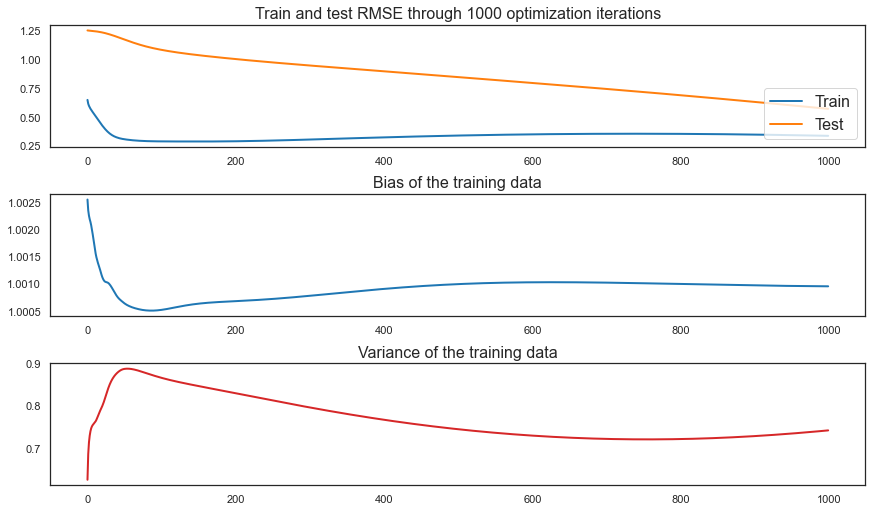

In [55]:
# Plot the evolution of train and test RMSE through the 1000 optimization iterations
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
spec = GridSpec(ncols=1, nrows=3, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(rmse, color='tab:blue', label='Train', linewidth=2)
ax0.plot(test_rmse, color='tab:orange', label='Test', linewidth=2)
#ax0.axvline(x=np.where(rmse == rmse.min()), color='red')
ax0.legend(loc='lower right', fontsize=16)
ax0.set_title('Train and test RMSE through 1000 optimization iterations', fontsize=16)

ax1 = fig.add_subplot(spec[1, 0])
ax1.plot(tr_bias, color='tab:blue', label='Bias', linewidth=2)
ax1.set_title('Bias of the training data', fontsize=16)

ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(tr_var, color='tab:red', label='Variance', linewidth=2)
ax2.set_title('Variance of the training data', fontsize=16)

In [56]:
# Train predictions
mean_train, var_train = m.predict_y(X_train)
# Test predictions
mean_test, var_test = m.predict_y(X_test)
# Full predictions (train + test)
# using the trained based normalisation (x_scaler)
mean, var = m.predict_y(x_scaler.transform(X))
_y = y_scaler.transform(y)

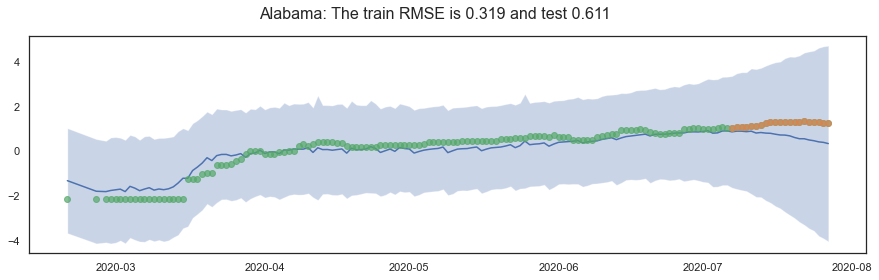

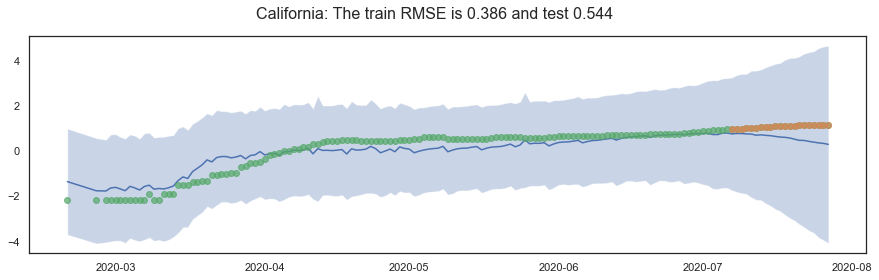

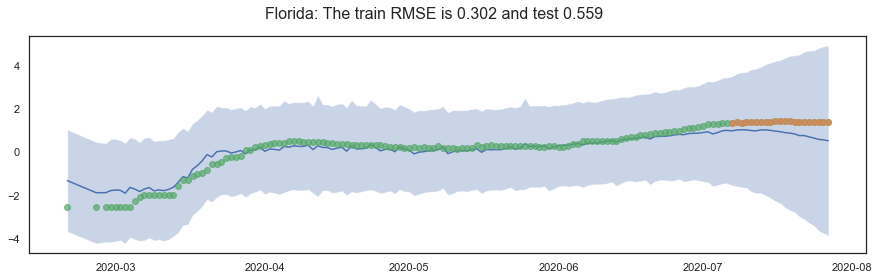

In [57]:
# 3 states

states_list = ["Alabama", "California", "Florida"]

t = final_data[["Updated_Alabama"]].to_numpy()

for s, state_name in enumerate(states_list):
    
    train_error = np.sqrt(np.mean((y_train[:, s] - mean_train[:, s])**2))
    test_error = np.sqrt(np.mean((y_test[:, s] - mean_test[:, s])**2))
    
    _fig, ax = plt.subplots(1, figsize=(15, 4))
    
    _fig.suptitle("{0}: The train RMSE is {1} and test {2}".format(state_name, np.round(train_error, 3), 
                                                                   np.round(test_error, 3)), fontsize=16)
    ax.plot(t, mean[:, s], "-", c="C0")
    lo = (mean[:, s] - 2 * tf.sqrt(var[:, s])).numpy()
    hi = (mean[:, s] + 2 * tf.sqrt(var[:, s])).numpy()
    ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(t, _y[:, s], "o", c="C2", alpha=0.7, label="train")
    ax.plot(t[-21:, :], _y[-21:, s], "o", c="C1", alpha=0.7, label="test")

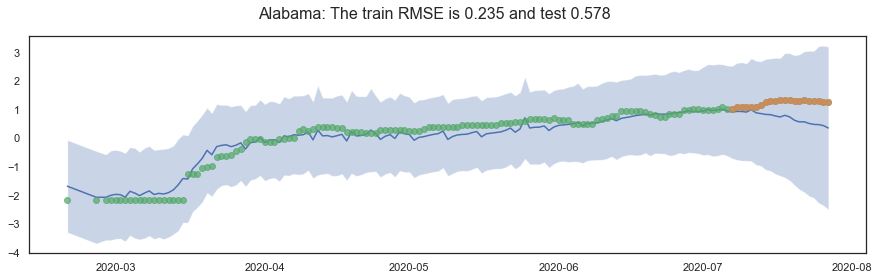

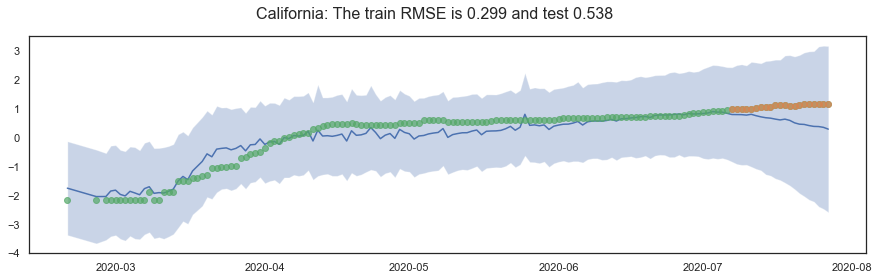

In [47]:
# 2 states
states_list = ["Alabama", "California"]

t = final_data[["Updated_Alabama"]].to_numpy()

for s, state_name in enumerate(states_list):
    
    train_error = np.sqrt(np.mean((y_train[:, s] - mean_train[:, s])**2))
    test_error = np.sqrt(np.mean((y_test[:, s] - mean_test[:, s])**2))
    
    _fig, ax = plt.subplots(1, figsize=(15, 4))
    
    _fig.suptitle("{0}: The train RMSE is {1} and test {2}".format(state_name, np.round(train_error, 3), 
                                                                   np.round(test_error, 3)), fontsize=16)
    ax.plot(t, mean[:, s], "-", c="C0")
    lo = (mean[:, s] - 2 * tf.sqrt(var[:, s])).numpy()
    hi = (mean[:, s] + 2 * tf.sqrt(var[:, s])).numpy()
    ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(t, _y[:, s], "o", c="C2", alpha=0.7, label="train")
    ax.plot(t[-21:, :], _y[-21:, s], "o", c="C1", alpha=0.7, label="test")